In [1]:
import cv2
import numpy as np
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")


GPU: Tesla T4


In [2]:
!ls

sample_data


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Indiantraffic.avi to Indiantraffic.avi


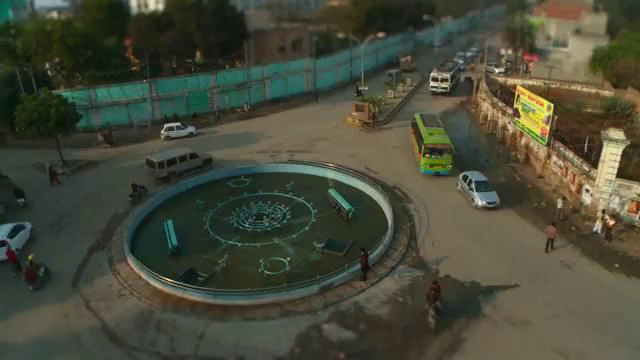

Resolution: 640x360


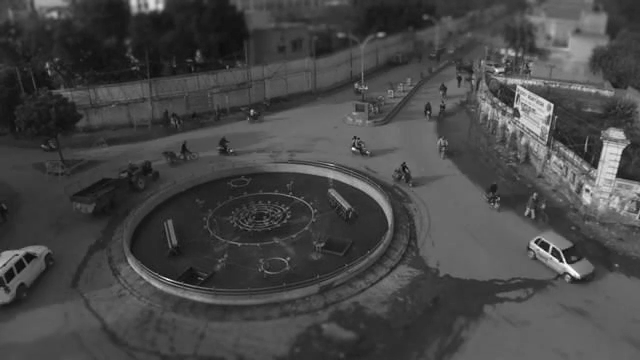

Resolution: 640x360
Video Tensor Shape: (900, 360, 640)


In [3]:
from google.colab.patches import cv2_imshow

# Read the video file
video_path = 'Indiantraffic.avi'
video_capture = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not video_capture.isOpened():
    print("Failed to open the video file")
    exit()

# Read the first frame from the video
ret, frame = video_capture.read()

# If the frame is successfully read
if ret:
    # Display the frame
    cv2_imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Get the resolution of the frame
    height, width, _ = frame.shape
    print("Resolution: {}x{}".format(width, height))
else:
    print("Failed to read the first frame")

# Initialize a list to store frames
frames = []

# Read the video frame by frame
while True:
    ret, frame = video_capture.read()

    # If the frame is successfully read
    if ret:
        # Convert the frame to grayscale if desired
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Add the frame to the list
        frames.append(gray_frame)
    else:
        break

# Release the video capture
video_capture.release()

# Check if frames were successfully read
if len(frames) == 0:
    print("No frames were read from the video file")
    exit()

# Convert the list of frames to a NumPy array
video_tensor = np.array(frames)

# Get a random frame index
random_index = np.random.randint(len(video_tensor))

# Get the random grayscale frame
random_frame = video_tensor[random_index]

# Display the random grayscale frame
cv2_imshow(random_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get the resolution of the random frame
height, width = random_frame.shape
print("Resolution: {}x{}".format(width, height))

# Print the shape of the video tensor
print("Video Tensor Shape:", video_tensor.shape)



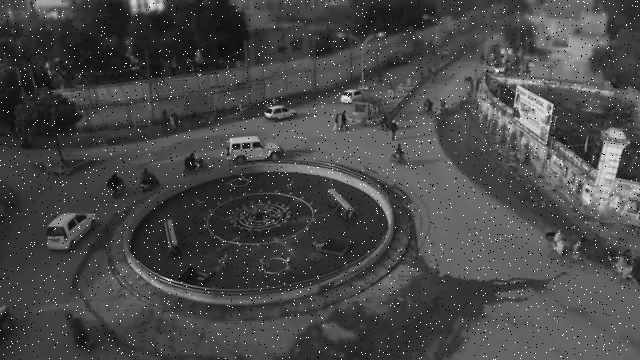

Resolution: 640x360
Noisy Video Tensor Shape: (900, 360, 640)


In [4]:
# Function to add salt and pepper noise to a single frame
def add_salt_pepper_noise(frame, noise_density):
    # Create a mask with random noise pixels
    mask = np.random.choice([0, 1, 2], size=frame.shape, p=[1 - noise_density, noise_density/2, noise_density/2])

    # Add salt noise (white pixels)
    salt = np.where(mask == 1)
    frame[salt] = 255

    # Add pepper noise (black pixels)
    pepper = np.where(mask == 2)
    frame[pepper] = 0

    return frame


# Get the shape of the video tensor
num_frames, height, width = video_tensor.shape

# Create an empty array to store the noisy frames
noisy_video_tensor = np.empty_like(video_tensor)

# Add salt and pepper noise to each frame
for i in range(num_frames):
    noisy_frame = add_salt_pepper_noise(video_tensor[i], noise_density=0.02)
    noisy_video_tensor[i] = noisy_frame

# Get a random frame index
random_index = np.random.randint(num_frames)

# Get the random noisy frame
random_frame = noisy_video_tensor[random_index]

# Display the random noisy frame
cv2_imshow(random_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the resolution of the random frame
height, width = random_frame.shape
print("Resolution: {}x{}".format(width, height))

# Print the shape of the noisy video tensor
print("Noisy Video Tensor Shape:", noisy_video_tensor.shape)

In [6]:
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 6.1 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt

In [7]:
from tensorly import backend as T
from tensorly.base import fold, unfold
from tensorly.tenalg.proximal import soft_thresholding, svd_thresholding

def robust_pca(
    X,
    mask=None,
    tol=10e-7,
    reg_E=1.0,
    reg_J=1.0,
    mu_init=10e-5,
    mu_max=10e9,
    learning_rate=1.1,
    n_iter_max=100,
    return_errors=False,
    verbose=1,
):

    if mask is None:
        mask = 1
    else:
        # Fix to address surprising MXNet.numpy behavior (Issue #19891)
        mask = T.tensor(mask, **T.context(X))

    # Initialise the decompositions
    D = T.zeros_like(X, **T.context(X))  # low rank part
    E = T.zeros_like(X, **T.context(X))  # sparse part
    L_x = T.zeros_like(
        X, **T.context(X)
    )  # Lagrangian variables for the (X - D - E - L_x/mu) term
    J = [
        T.zeros_like(X, **T.context(X)) for _ in range(T.ndim(X))
    ]  # Low-rank modes of X
    L = [T.zeros_like(X, **T.context(X)) for _ in range(T.ndim(X))]  # Lagrangian or J

    # Norm of the reconstructions at each iteration
    rec_X = []
    rec_D = []

    mu = mu_init

    for iteration in range(n_iter_max):
        print(f"Iteration {iteration + 1}")
        for i in range(T.ndim(X)):
            J[i] = fold(
                svd_thresholding(unfold(D, i) + unfold(L[i], i) / mu, reg_J / mu),
                i,
                X.shape,
            )

        D = L_x / mu + X - E
        for i in range(T.ndim(X)):
            D += J[i] - L[i] / mu
        D /= T.ndim(X) + 1

        E = soft_thresholding(X - D + L_x / mu, mask * reg_E / mu)
        L = [T.zeros_like(X, **T.context(X)).astype(float) for _ in range(T.ndim(X))]  # Lagrangian or J
        # Update the lagrangian multipliers
        for i in range(T.ndim(X)):
            L[i] += mu * (D - J[i])

        L_x += mu * (X - D - E)

        mu = min(mu * learning_rate, mu_max)

        # Evolution of the reconstruction errors
        rec_X.append(T.norm(X - D - E, 2))
        rec_D.append(T.max(T.tensor([T.norm(low_rank - D, 2) for low_rank in J])))

        # Convergence check
        if iteration > 1:
            if rec_X[-1] <= tol and rec_D[-1] <= tol:
                if verbose:
                    print(f"\nConverged in {iteration} iterations")
                break

    if return_errors:
        return D, E, rec_X, iteration
    else:
        return D, E, iteration

In [8]:
def visualise_rpca(X, low_rank_part, sparse_part, n_samples=10):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_samples]

    fig, axes = plt.subplots(n_samples, 4, figsize=(12, 3*n_samples))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.3, wspace=0.05)

    for i, idx in enumerate(indices):
        cmap = plt.cm.Greys_r

        axes[i, 0].imshow(X[idx], cmap=cmap, interpolation='nearest')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title('Original')

        axes[i, 1].imshow(low_rank_part[idx], cmap=cmap, interpolation='nearest')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title('Low-rank')

        axes[i, 2].imshow(sparse_part[idx], cmap=cmap, interpolation='nearest')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title('Sparse')

        axes[i, 3].imshow(low_rank_part[idx] + sparse_part[idx], cmap=cmap, interpolation='nearest')
        axes[i, 3].set_xticks([])
        axes[i, 3].set_yticks([])
        if i == 0:
            axes[i, 3].set_title('Reconstruction')

    plt.show()


import numpy as np

def calculate_reconstruction_error(X, low_rank_part, sparse_part):
    reconstruction_error = np.linalg.norm(X - (low_rank_part + sparse_part), ord='fro', axis=(1, 2))
    return reconstruction_error



In [9]:
print("Shape of the noisy video tensor:", noisy_video_tensor.shape)
selected_frames = noisy_video_tensor[:100]
print("Shape of the selected frames:", selected_frames.shape)
selected_frames = selected_frames.astype(float)

Shape of the noisy video tensor: (900, 360, 640)
Shape of the selected frames: (100, 360, 640)


In [55]:
low_rank_part, sparse_part, iterations = robust_pca(selected_frames, reg_E=0.1,reg_J=7, learning_rate=1.2, n_iter_max=70)
print('selected_frames.shape={} == low_rank_part.shape={} == sparse_part.shape={}.'.format(selected_frames.shape, low_rank_part.shape, sparse_part.shape))
print('Iterations:', iterations)



Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
selected_frames.shape=(100, 360, 640) == low_rank_part.shape=(100, 360, 640) == sparse_part.shape=(

In [56]:
reconstruction_errors = calculate_reconstruction_error(selected_frames, low_rank_part, sparse_part)
average_error = np.mean(reconstruction_errors)

print("Reconstruction Errors for each frame:")
print(reconstruction_errors)
print("Average Reconstruction Error: ", average_error)

Reconstruction Errors for each frame:
[0.00449957 0.00442191 0.00442204 0.00442456 0.00439524 0.00437065
 0.00434035 0.00437398 0.00440511 0.00438202 0.00441625 0.00441626
 0.00437798 0.0044488  0.00441087 0.00438797 0.00442589 0.00436845
 0.00444978 0.0043789  0.0043437  0.00432403 0.00437423 0.00433172
 0.00430592 0.00430586 0.00431173 0.00422985 0.00418699 0.00422283
 0.00427733 0.00425217 0.00427554 0.0043239  0.00424579 0.00433467
 0.00432853 0.00437301 0.00431034 0.00431454 0.00433584 0.00439412
 0.00439214 0.00432324 0.00431569 0.00433001 0.00439411 0.00428534
 0.00426551 0.00427536 0.00429217 0.00427236 0.00427114 0.00427912
 0.00430931 0.00423167 0.00423544 0.00430053 0.00424698 0.00424678
 0.0042673  0.00431917 0.00428725 0.00430794 0.00435555 0.00436044
 0.00439324 0.00438637 0.0044092  0.00439267 0.00442302 0.00436104
 0.00434816 0.00435513 0.00439353 0.00434034 0.00434129 0.00434601
 0.004387   0.00436168 0.00436749 0.00436836 0.00439126 0.00435942
 0.00434999 0.00433947 0

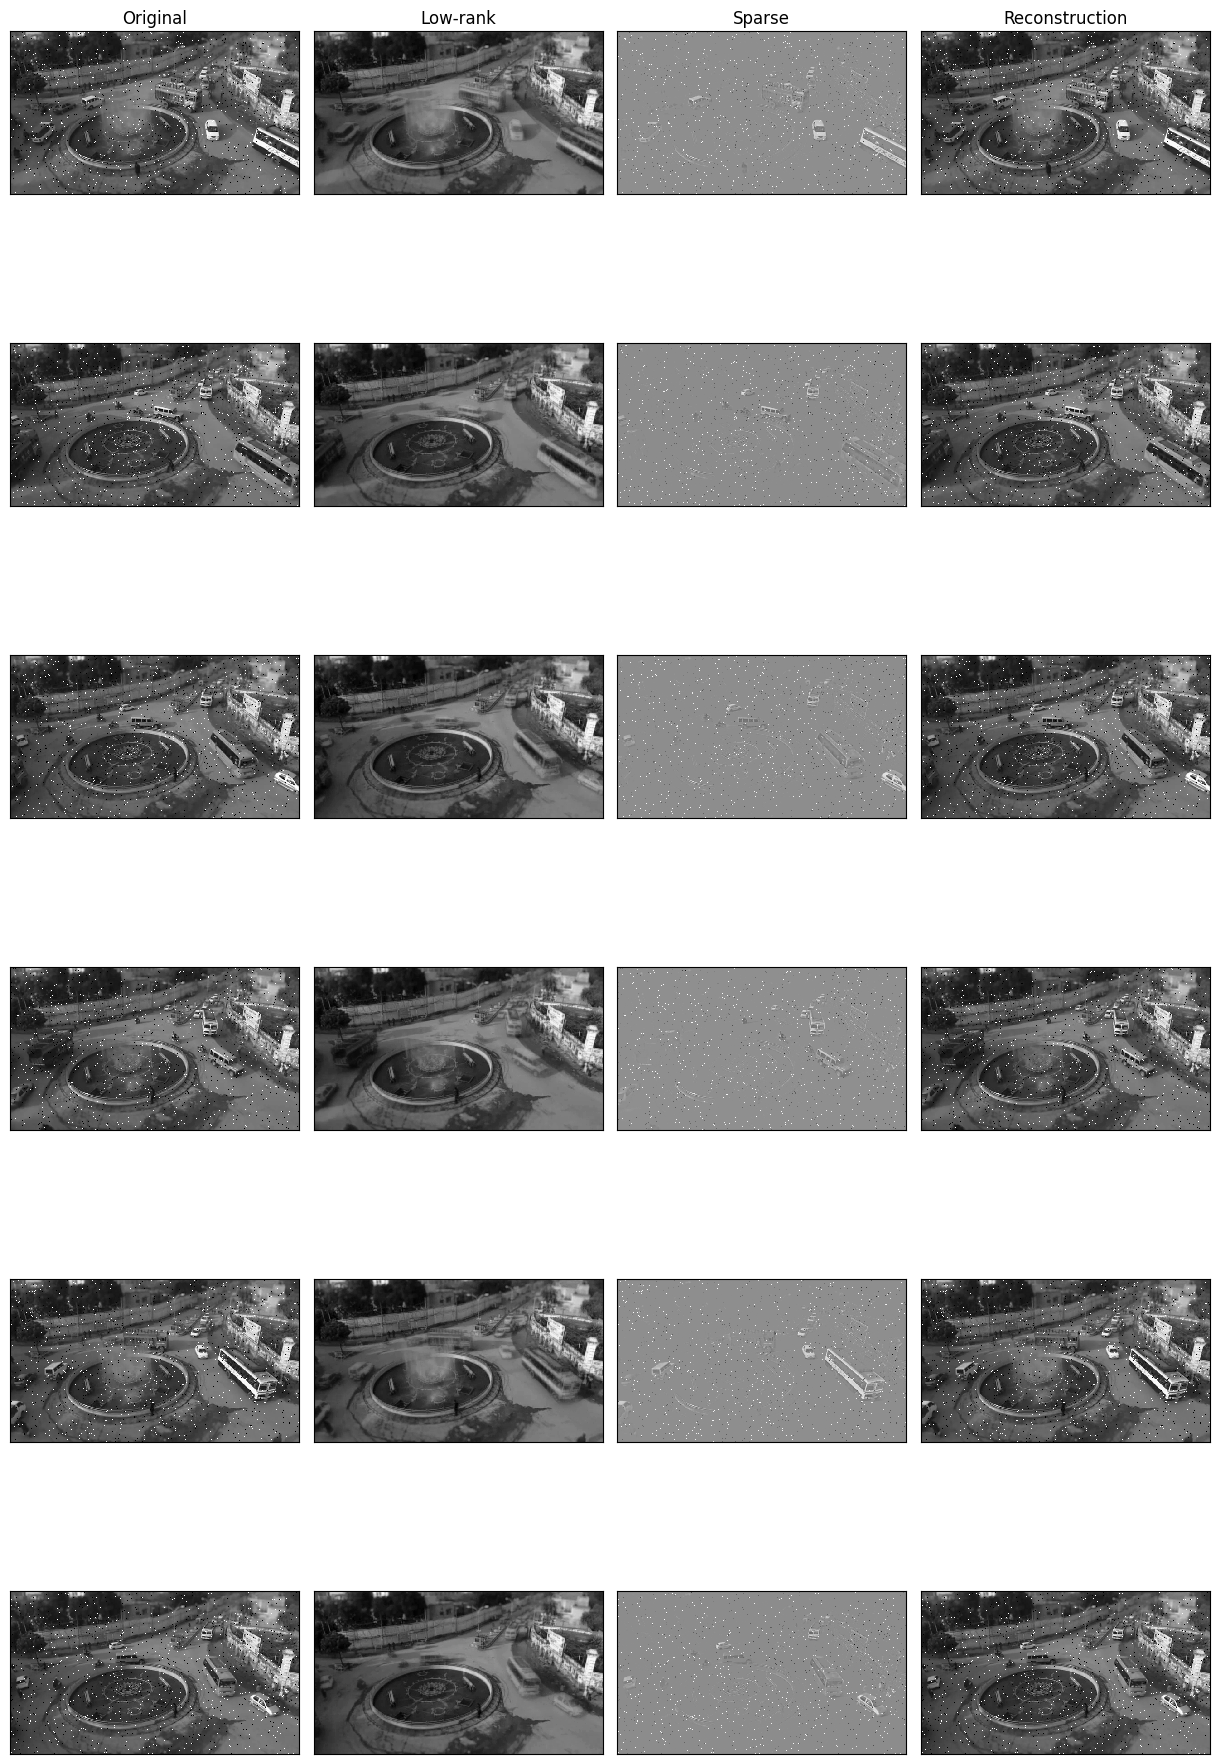

In [59]:
visualise_rpca(selected_frames, low_rank_part, sparse_part, n_samples=6)

In [60]:
low_rank_part, sparse_part, iterations = robust_pca(selected_frames, reg_E=0.1,reg_J=9, learning_rate=1.2, n_iter_max=70)
print('selected_frames.shape={} == low_rank_part.shape={} == sparse_part.shape={}.'.format(selected_frames.shape, low_rank_part.shape, sparse_part.shape))
print('Iterations:', iterations)


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
selected_frames.shape=(100, 360, 640) == low_rank_part.shape=(100, 360, 640) == sparse_part.shape=(

In [61]:
reconstruction_errors = calculate_reconstruction_error(selected_frames, low_rank_part, sparse_part)
average_error = np.mean(reconstruction_errors)

print("Reconstruction Errors for each frame:")
print(reconstruction_errors)
print("Average Reconstruction Error: ", average_error)

Reconstruction Errors for each frame:
[0.00476384 0.00467212 0.00465471 0.00460793 0.00458422 0.00458166
 0.00461921 0.00462886 0.00463171 0.00464487 0.00464754 0.00463432
 0.00465874 0.00461217 0.00464097 0.00461288 0.0046103  0.00461014
 0.00459848 0.0045822  0.00452246 0.00453514 0.00450214 0.00455963
 0.00456544 0.00456409 0.00453138 0.00448011 0.00446131 0.00445893
 0.0044717  0.00449889 0.00452751 0.00451904 0.00448838 0.00453208
 0.00458245 0.00459207 0.00458315 0.00460054 0.00462467 0.00457271
 0.00457975 0.00456684 0.00456814 0.00457486 0.0045606  0.004543
 0.00452616 0.00453651 0.0044954  0.00449984 0.00449459 0.0045129
 0.00449117 0.00445798 0.00445917 0.00446782 0.00449923 0.00451704
 0.00450803 0.00448381 0.00449293 0.00451608 0.00450749 0.00453004
 0.00450818 0.00454064 0.00452444 0.00452899 0.00449317 0.00450574
 0.00449692 0.00451475 0.00449438 0.00450904 0.00453492 0.00456726
 0.00452464 0.00454915 0.00457382 0.00457181 0.00454177 0.00456528
 0.00457508 0.00456665 0.00

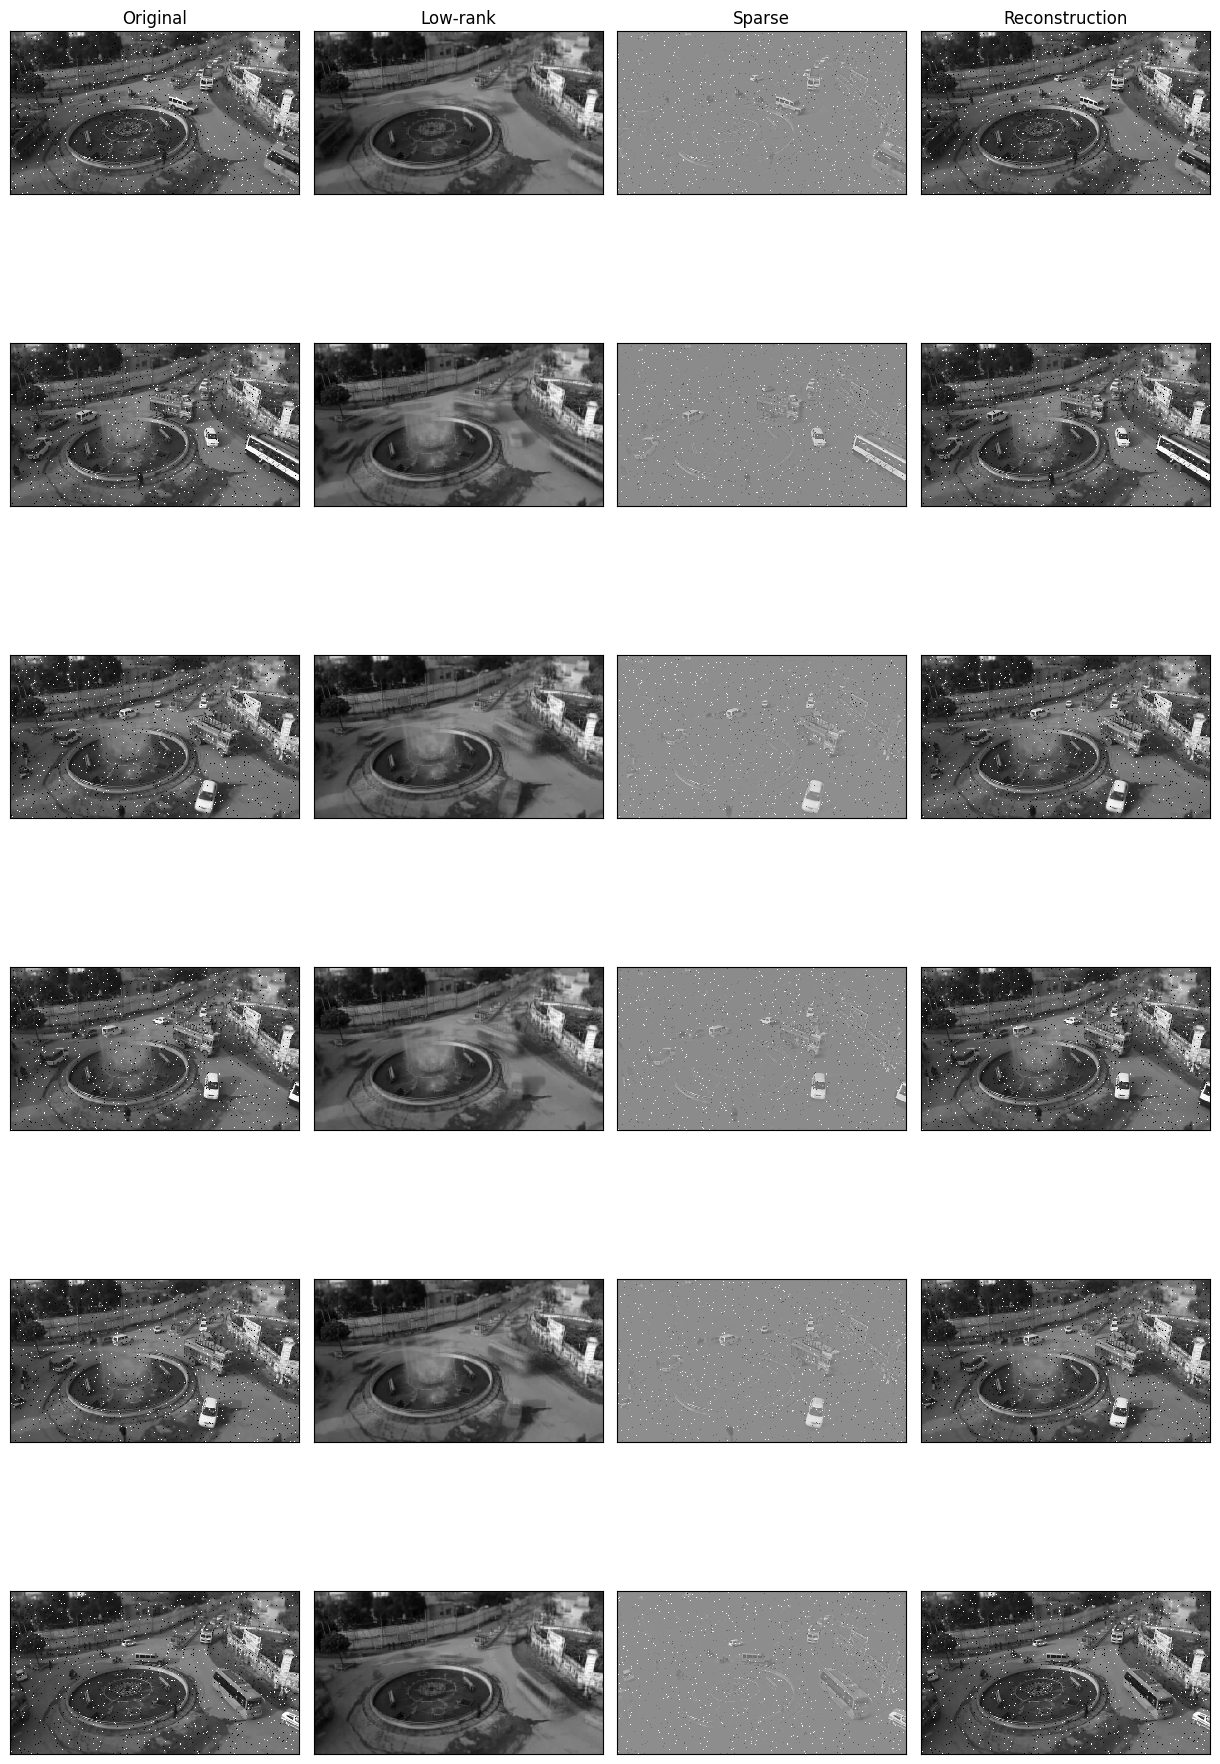

In [62]:
visualise_rpca(selected_frames, low_rank_part, sparse_part, n_samples=6)

In [10]:
low_rank_part, sparse_part, iterations = robust_pca(selected_frames, reg_E=0.1,reg_J=11, learning_rate=1.2, n_iter_max=70)
print('selected_frames.shape={} == low_rank_part.shape={} == sparse_part.shape={}.'.format(selected_frames.shape, low_rank_part.shape, sparse_part.shape))
print('Iterations:', iterations)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
selected_frames.shape=(100, 360, 640) == low_rank_part.shape=(100, 360, 640) == sparse_part.shape=(

In [11]:
reconstruction_errors = calculate_reconstruction_error(selected_frames, low_rank_part, sparse_part)
average_error = np.mean(reconstruction_errors)

print("Reconstruction Errors for each frame:")
print(reconstruction_errors)
print("Average Reconstruction Error: ", average_error)

Reconstruction Errors for each frame:
[0.00350579 0.00338397 0.00339906 0.00336883 0.00334063 0.00334327
 0.00341902 0.00338622 0.00337853 0.00339603 0.00333831 0.00330759
 0.00336531 0.00330372 0.00333002 0.0033347  0.00329103 0.00330428
 0.00327207 0.00325002 0.00323179 0.0032227  0.00317618 0.00328336
 0.0033032  0.00330157 0.00324683 0.00323731 0.00327121 0.00326878
 0.0032563  0.00329295 0.00330184 0.0032766  0.00324678 0.00324325
 0.00329864 0.00327745 0.00333574 0.00334612 0.00334636 0.00328562
 0.00325779 0.00331401 0.00331829 0.00331862 0.0032584  0.003288
 0.00328298 0.003295   0.00321018 0.00327164 0.00328433 0.0032776
 0.00322956 0.00321895 0.00322295 0.00317646 0.00326818 0.00328221
 0.00329188 0.00324286 0.00325202 0.00325085 0.00320429 0.00324916
 0.00317708 0.00322222 0.00320691 0.00320957 0.00312445 0.00319142
 0.00318542 0.00318225 0.00312517 0.00320633 0.00323135 0.00325786
 0.00317567 0.00325942 0.00327024 0.00327102 0.00323953 0.00327348
 0.00329143 0.00327833 0.00

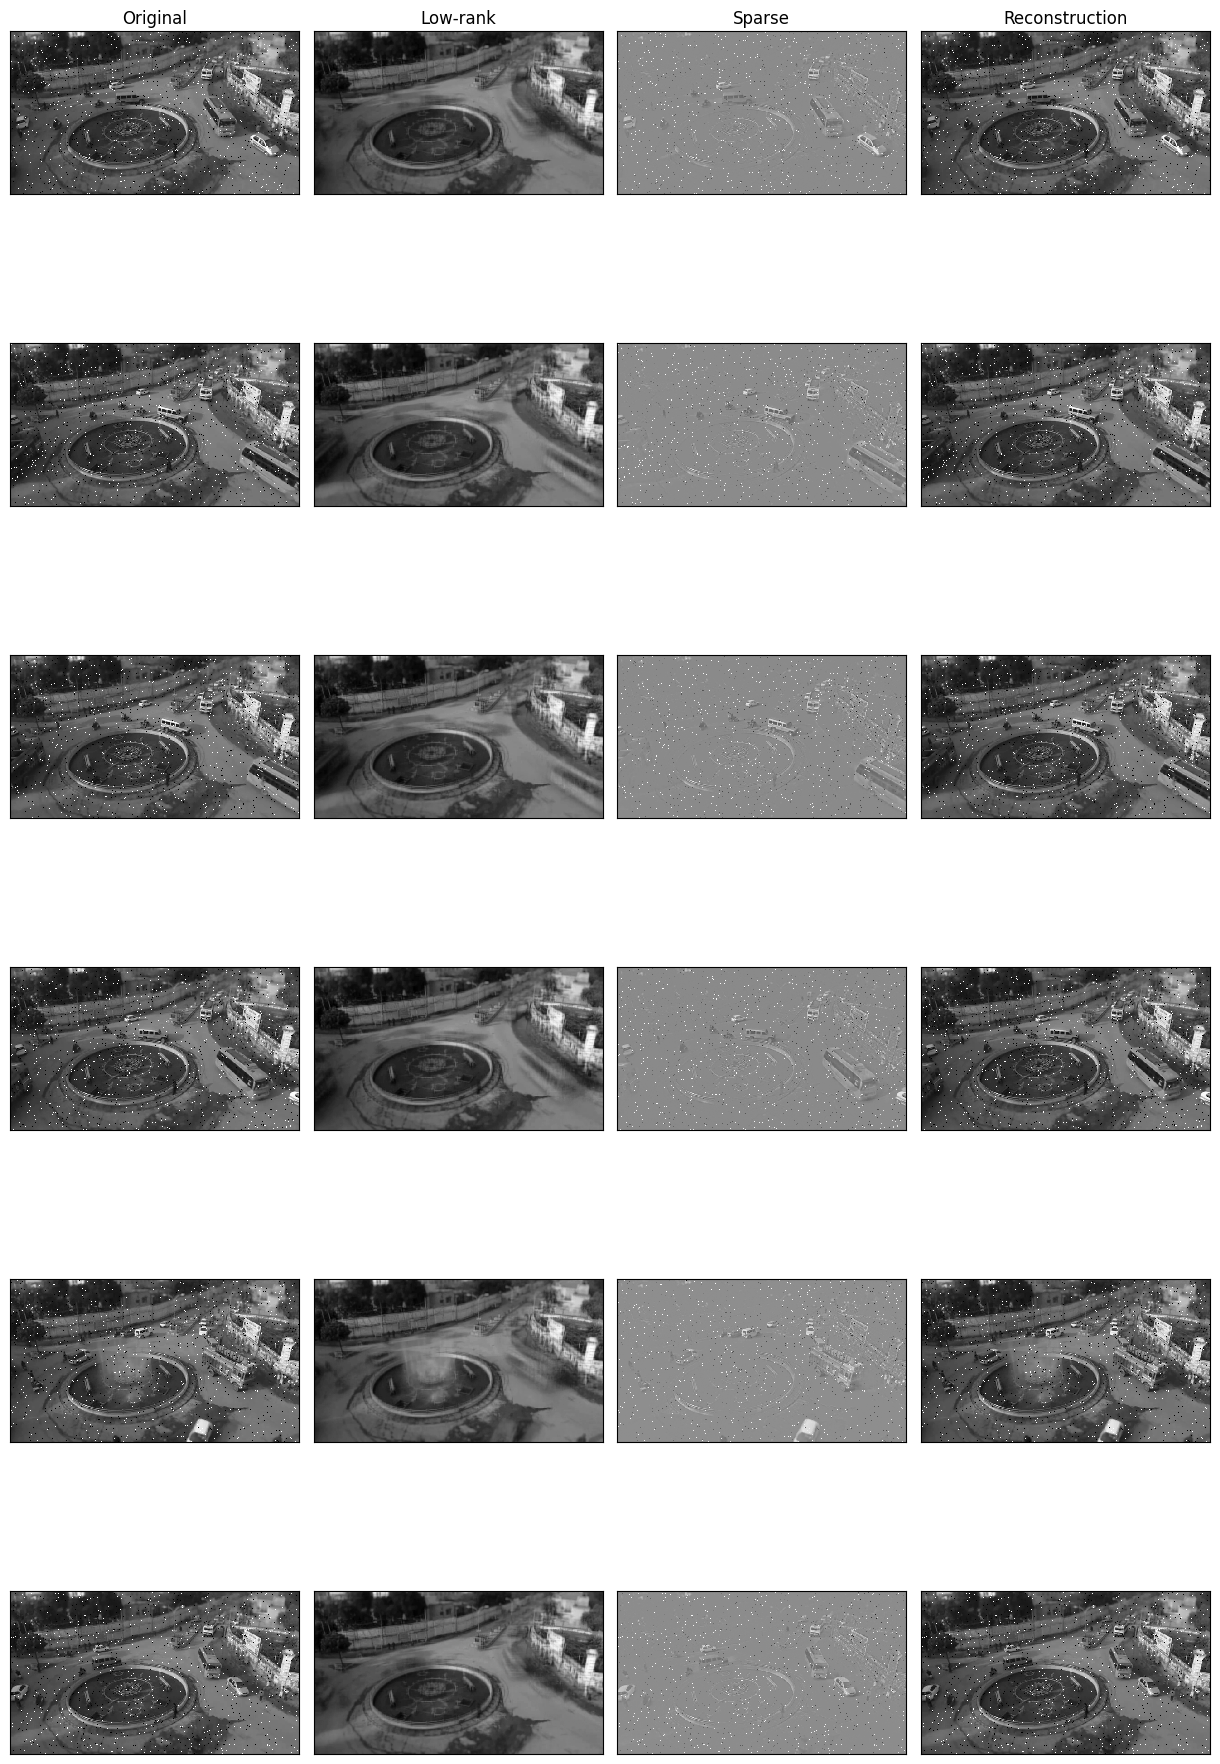

In [12]:
visualise_rpca(selected_frames, low_rank_part, sparse_part, n_samples=6)

In [13]:
def normalise(array):
    if array.min() < 0 or array.max() > 255:
        array = (array - array.min()) / (array.max() - array.min()) * 255
    return np.repeat(array[..., np.newaxis], 3, axis=-1).astype(np.uint8)

(100, 360, 640)
(100, 360, 640, 3)
(100, 360, 640, 3)
(100, 360, 640, 3)
(100, 360, 640)
(100, 360, 640)


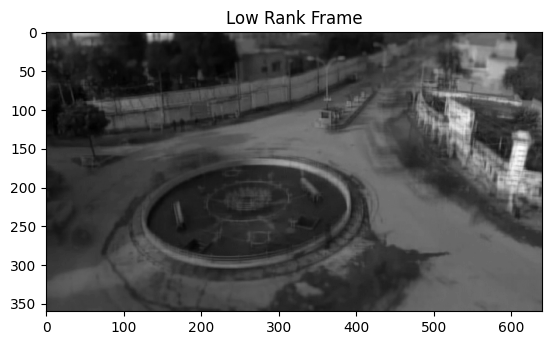

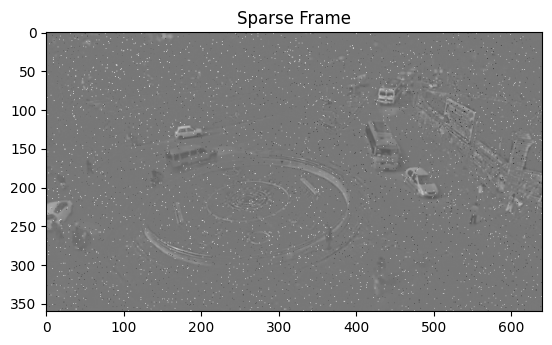

In [15]:
low_rank = normalise(low_rank_part)
sparse = normalise(sparse_part)
print(low_rank_part.shape)
print(low_rank.shape)
# Reshaping low_rank
low_rank = np.squeeze(low_rank)

# Reshaping sparse
sparse = np.squeeze(sparse)

# Printing the new shapes
print(low_rank.shape)
print(sparse.shape)

# Remove the last dimension from low_rank
low_rank = low_rank[..., 0]

# Remove the last dimension from sparse
sparse = sparse[..., 0]

# Printing the new shapes
print(low_rank.shape)
print(sparse.shape)
import matplotlib.pyplot as plt

# Assuming low_rank and sparse are already defined as (100, 360, 640)

# Display one frame from low_rank
plt.imshow(low_rank[0], cmap='gray')
plt.title("Low Rank Frame")
plt.show()

# Display one frame from sparse
plt.imshow(sparse[0], cmap='gray')
plt.title("Sparse Frame")
plt.show()

In [25]:
from PIL import Image

def resize_images_to_average(images, avg_width, avg_height):
    """Resize all images in the list to the provided average dimensions."""
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (avg_width, avg_height), interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return resized_images

def create_video_from_images(images, output_filename):
    """Generate a video from the list of images."""
    first_image = images[0]
    h, w = first_image.shape[:2]  # Retrieve height and width only

    codec = cv2.VideoWriter_fourcc(*'MJPG')  # Use MJPG codec for AVI format
    vid_writer = cv2.VideoWriter(output_filename, codec, 20, (w, h), isColor=False)  # Set isColor=False for grayscale images

    for img in images:
        vid_writer.write(img)

    vid_writer.release()

# Example usage
images = low_rank
avg_width = 640
avg_height = 360

# Resize images to average dimensions
resized_images = resize_images_to_average(images, avg_width, avg_height)

# Create video from resized images
create_video_from_images(resized_images, 'background.avi')

# Example usage
images = sparse
avg_width = 640
avg_height = 360

# Resize images to average dimensions
resized_images = resize_images_to_average(images, avg_width, avg_height)

# Create video from resized images
create_video_from_images(resized_images, 'foreground.avi')

In [26]:
!ls

background.avi	   created_video.mp4  Indiantraffic.avi
created_video.avi  foreground.avi     sample_data


In [27]:
from google.colab import files

# Download the animation file
files.download('foreground.avi')
files.download('background.avi')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>